## HeartFailure data preprocessing

### Importing necessary libraries

In [1]:
import os
import sys
current_directory=os.getcwd()
parent_directory=os.path.dirname(current_directory)
sys.path.append(parent_directory)


In [2]:
import numpy as np
from library.generators.NextConvGeN import NextConvGeN


2024-01-31 12:02:28.321661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-31 12:02:28.321680: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
from fdc.clustering import *

In [4]:
import pandas as pd

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Importing data

In [6]:
data=pd.read_csv('preprocessed_stroke_data.csv')

In [7]:
data=data.sample(frac=1, random_state=42)

In [8]:
data

,Unnamed: 0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4664,4857,1,32.0,0,0,1,0,0,102.13,32.3,0,0
3542,3709,0,42.0,0,0,0,0,1,84.03,31.4,0,0
907,964,1,66.0,1,0,1,0,0,74.90,32.1,0,0
2833,2971,0,21.0,0,0,0,0,0,71.06,25.3,1,0
3106,3262,1,47.0,0,0,1,0,0,88.49,22.2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4426,4614,0,78.0,0,0,1,3,0,61.38,24.3,-1,0
466,511,0,51.0,0,0,1,0,0,82.93,29.7,2,0
3092,3248,0,35.0,1,0,1,0,1,94.20,34.4,2,0
3772,3947,1,61.0,0,0,1,1,1,116.78,39.8,1,0


In [9]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [10]:
data.drop(['Unnamed: 0'],axis=1, inplace=True)

In [11]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/Stroke.csv")
data.to_csv(output_file_path, index=False)

In [12]:
data['stroke'].value_counts()

0    4699
1     209
Name: stroke, dtype: int64

In [13]:
data.drop(['stroke'],axis=1, inplace=True)

In [14]:
np.random.seed(42)
data=data.sample(frac=1)

### UMAP on entire data

In [15]:
from fdc.fdc import feature_clustering

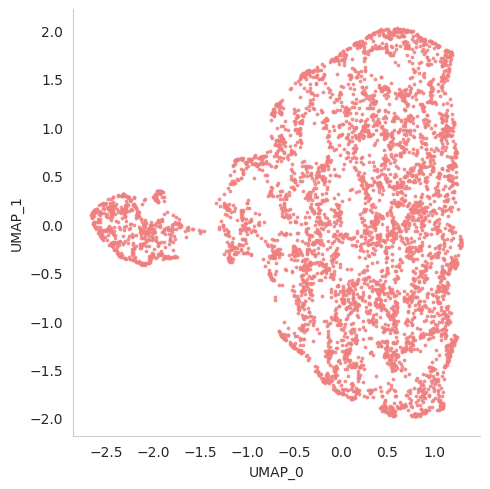

In [16]:
np.random.seed(42)
umap_emb=feature_clustering(30,0.1,'euclidean',data,True)

### Feature-type Distributed Clustering (FDC)

In [17]:
nom_list=['gender','ever_married','work_type','Residence_type']

ord_list=['hypertension','heart_disease','smoking_status']

cont_list=['age','avg_glucose_level', 'bmi']

target = ['stroke']


In [18]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/Stroke.json")

In [19]:
import json

features = {
    "cont_list": cont_list,
    "nom_list": nom_list,
    "ord_list": ord_list,
    "target": target
}

with open(output_file_path, "w") as json_file:
    json.dump(features, json_file)

FDC.normalize (init): 0.00001 / 0.000s


FDC.normalize (clustering CONT): 10.08787 / 10.088s


FDC.normalize (clustering ORD): 77.39436 / 87.482s
FDC.normalize (clustering NOM): 0.00007 / 87.482s
FDC.normalize (concat): 0.00020 / 87.483s


FDC.normalize (umap 5 -> 2): 11.25196 / 98.734s
FDC.normalize (array -> DataFrame): 0.00027 / 98.735s


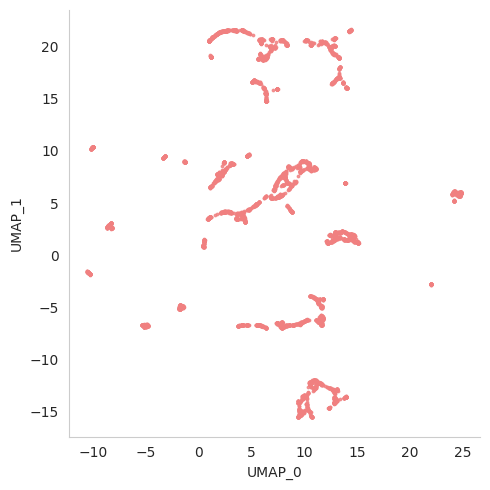

FDC.normalize (plotting): 0.41777 / 99.153s
FDC.normalize (array -> DataFrame): 0.00018 / 99.153s
FDC.normalize (total): 0.00001 / 99.153s


In [20]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)

fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

### Clustering using K-means

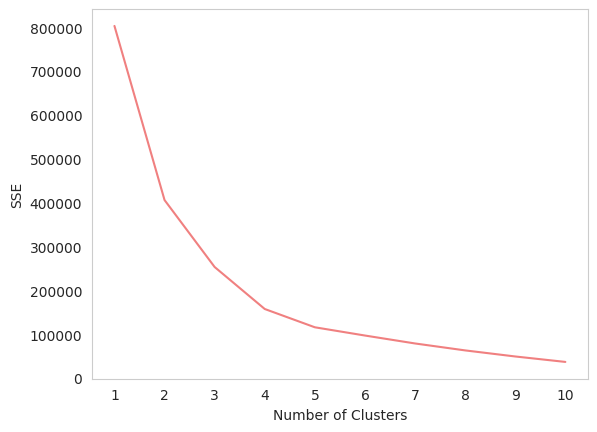

In [21]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(FDC_emb_low)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [22]:
def find_optimal_cluster(FDC_emb_low):
    silhouette_scores = []

    for n_clusters in list(range(2, 9)):
        km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)

        km.fit(FDC_emb_low)

        labels = km.labels_

        # Compute the silhouette score
        silhouette_avg = silhouette_score(FDC_emb_low, labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [23]:
find_optimal_cluster(FDC_emb_low)

[0.44019127,
 0.47069055,
 0.51529866,
 0.5420453,
 0.5370034,
 0.5488177,
 0.5475534]

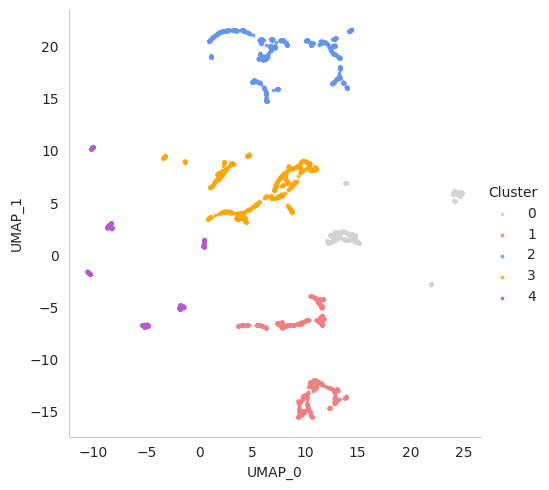

In [24]:
from fdc.clustering import *
np.random.seed(42)
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(5)

In [25]:
cluster_counts

array([ 583, 1141, 1351, 1358,  475])

In [26]:
data['Target']=cluster_list

In [27]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/SSStroke.csv")
data.to_csv(output_file_path, index=False)

In [28]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,Target
4664,0,18.00,0,0,0,0,0,80.06,31.8,-1,2
3542,0,54.00,0,0,1,0,0,111.41,31.1,0,3
907,1,0.32,0,0,0,2,1,89.04,17.8,-1,2
2833,1,23.00,0,0,0,0,0,67.76,26.0,0,3
3106,0,82.00,1,0,1,0,1,115.71,31.1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4426,0,50.00,0,0,1,0,0,217.39,50.6,-1,4
466,1,49.00,1,0,1,1,0,92.26,33.1,1,0
3092,0,5.00,0,0,0,2,0,92.00,17.9,-1,2
3772,1,71.00,1,0,1,0,0,186.95,33.3,0,4
